## Final Project: Global Sea Level Fingerprint

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

from scipy import interpolate as interp 
import scipy.optimize as opt
from scipy.interpolate import griddata
from scipy import interpolate as interp
from scipy.optimize import curve_fit as curve_fit
import numpy.polynomial.polynomial as poly

from cartopy import crs as ccrs
import cartopy.feature as cfeature
from matplotlib import path
from matplotlib import colorbar as colorbar
import cmocean

import pyshtools
from pathlib import Path

In [2]:
# Load Ice Masks on a GL grid 
# WAIS ice mask; lon, lat, bool
wais = np.loadtxt('WAIS_mask_new.txt')

# Greenland ice mask; lon, lat, bool
gris = np.loadtxt('Greenland_mask_new.txt')
gris

array([[ 1.2000e-01, -8.9880e+01,  0.0000e+00],
       [ 3.8000e-01, -8.9880e+01,  0.0000e+00],
       [ 6.2000e-01, -8.9880e+01,  0.0000e+00],
       ...,
       [ 3.5938e+02,  8.9880e+01,  0.0000e+00],
       [ 3.5962e+02,  8.9880e+01,  0.0000e+00],
       [ 3.5988e+02,  8.9880e+01,  0.0000e+00]])

In [3]:
etopo = np.loadtxt('etopo_ice_15.txt')

In [4]:
ind_i = np.lexsort((etopo[:,1], etopo[:,0]))
ind_w = np.lexsort((wais[:,1], wais[:,0]))
ind_g = np.lexsort((gris[:,1], gris[:,0]))

etopo = etopo[ind_i]
wais = wais[ind_w]
gris = gris[ind_g]

In [5]:
lmax = 256

def reshape_mask(etopo,lmax):
    num1 = np.unique(etopo[:,0]).size
    num2 = np.unique(etopo[:,1]).size
    lon2 = np.reshape(etopo[:,0],(num1,num2)).T
    lat2 = np.reshape(etopo[:,1],(num1,num2)).T
    topo2 = np.reshape(etopo[:,2],(num1,num2)).T
    topo_interp = interp.interp2d(lon2[1,:],lat2[:,1],topo2)
    latglq, longlq = pyshtools.expand.GLQGridCoord(lmax) 
    topoglq2 = topo_interp(longlq,latglq)
    return topoglq2, longlq, latglq

<ipython-input-6-3df11787e60d>:2: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(e_long, e_lat, topogl);


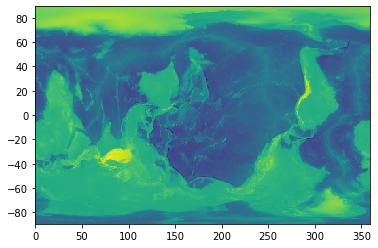

In [6]:
topogl, e_long, e_lat = reshape_mask(etopo,lmax)
plt.pcolormesh(e_long, e_lat, topogl);

# West Antarctic Ice Sheet (WAIS)

In [9]:
wais_h, w_lon, w_lat = reshape_mask(wais,lmax)

<ipython-input-10-41b167e2ab24>:1: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(e_long, e_lat, wais_h);


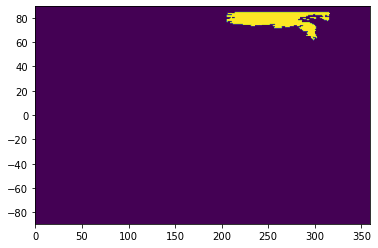

In [10]:
plt.pcolormesh(e_long, e_lat, wais_h);

In [11]:
#### del_i
wais_is = topogl*wais_h
del_i = - wais_is

<ipython-input-12-95734bf2f44d>:1: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(e_long, e_lat, wais_is)


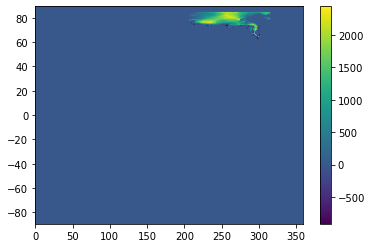

In [12]:
plt.pcolormesh(e_long, e_lat, wais_is)
plt.colorbar()

In [13]:
zero, w = pyshtools.expand.SHGLQ(lmax)
## Spherical harmonic tranform of change in ice, del_I
del_I_lm = pyshtools.expand.SHExpandGLQC(del_i,w,zero,norm=1,csphase=1,lmax_calc=lmax)
# define 0,0 component of change in ice, del_I
del_I_00= del_I_lm[0,0,0]
del_I_lm.shape

(2, 257, 257)

In [14]:
## construct ocean function, C(theta, psi)
def ocean_function(topo):
    topo[topo > 0] = 0
    topo[topo < 0] = 1
    return topo 

oceanfunc = ocean_function(topogl)

In [15]:
## Spherical harmonic tranform of ocean function, delC(l,m)
del_C_lm = pyshtools.expand.SHExpandGLQC(oceanfunc,w,zero,norm=1,csphase=1,lmax_calc=lmax)
# 0,0 component of ocean function 
del_C_00 = del_C_lm[0,0,0]
del_C_lm.shape

(2, 257, 257)

In [16]:
#density of water kg/m3
rho_w = 1000
#density of ice kg/m3
rho_i = 919 
# radius of earth (a) from km to m 
a = 6371*1000
# mass of the earth (kg)
Me = 5.972e24

In [17]:
#### INITIAL GUESS
del_S = -(rho_i/rho_w)*(np.real(del_I_00/del_C_00))*oceanfunc

In [18]:
# Spherical harmonic tranform 
del_S_lm = pyshtools.expand.SHExpandGLQC(del_S,w,zero,norm=1,csphase=1,lmax_calc=lmax)

##### Load Love Numbers
- Column 1 - degree
- Column 2 - elastic h Love number
- Column 3 - elastic k Love number
- Column 4 - degree * elastic k Love number  (you don't need this, but this is typically how the k Love number is provided, since the scaling makes the h and k Love numbers roughly the same size).

In [19]:
# calculate T_l
ls = np.arange(257)
a = 6371 * 1000 # m
M_e = 5.972e24 # kg
T_l = ((4*np.pi*a**3)/(M_e * (2*ls + 1)))
#T_l.reshape(1,257,1);

In [20]:
# calculate E_l

E_h = np.loadtxt('lovenumbers.txt',comments='%')[:,1]
E_k = np.loadtxt('lovenumbers.txt',comments='%')[:,2]
E_ls = (np.ones_like(E_h) + E_k - E_h)[:lmax+1]
#.reshape(1,257,1)
#E_ls.shape

In [21]:
# define CurlySL before for loop or else error that curly_SL_lm does not exist (it then gets written over every time)
curly_SL_lm = E_ls*T_l*((rho_i*del_I_lm)+(rho_w*del_S_lm))

In [22]:
for i in range(5):
    
    for j in range(2):
        for l in range(257):
            for m in range(257):
                curly_SL_lm[j,l,m] = E_ls[l]*T_l[l]*((rho_i*del_I_lm[j,l,m])+(rho_w*del_S_lm[j,l,m]))
                
    ############## Inverse Spherical harmonic transform
    curly_SL_tp = pyshtools.expand.MakeGridGLQC(curly_SL_lm,zero,lmax=lmax,norm=1,csphase=1,lmax_calc=lmax)
    
    del_RO = curly_SL_tp * oceanfunc
    del_RO_00 = del_RO[0,0]
    
    delphig = -(rho_i/rho_w)*(del_I_00/del_C_00) - (del_RO_00/del_C_00)
    
    del_S_delphig = (curly_SL_tp + delphig)*oceanfunc
    
    ############## Spherical harmonic transform
    del_s_lm = pyshtools.expand.SHExpandGLQC(del_S_delphig,w,zero,norm=1,csphase=1,lmax_calc=lmax)
    
    print(i)

0
1
2
3
4


In [23]:
# final sea level 
del_SL_final = curly_SL_tp + delphig

# normalize sea level to 1 
del_S_lm00 = (del_s_lm[0,0][0])/(del_C_00)
slchange = np.real(del_SL_final/del_S_lm00)

In [24]:
slchange.shape

(257, 513)

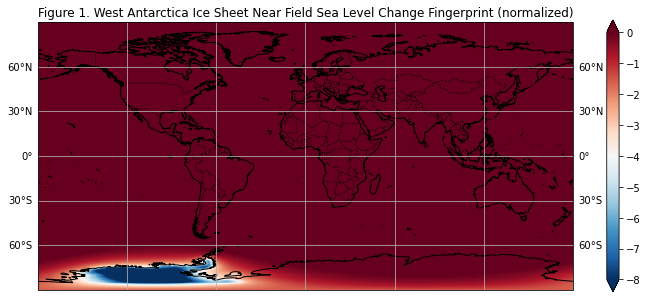

In [32]:
f1 = plt.figure(figsize=(12,10))
ax1 = f1.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
# add gridlines
ax1.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
def add_features(ax):
    # add coastal features
    ax.add_feature(cfeature.LAND)
    ax.add_feature(cfeature.OCEAN)
    ax.add_feature(cfeature.COASTLINE.with_scale('50m'))
    ax.add_feature(cfeature.BORDERS, linestyle=':')
    return ax
ax1 = add_features(ax1)
t1 = ax1.pcolormesh(e_long, -e_lat,slchange, cmap = 'RdBu_r', vmin = -8, vmax = 0)
cb = f1.colorbar(t1, ax=ax1, shrink=0.50, extend='both')
# cb.set_label(label='Ocean Function',size=5)
plt.title('Figure 1. West Antarctica Ice Sheet Near Field Sea Level Change Fingerprint (normalized)')
plt.show()

In [34]:
f1.savefig('f1_WAIS_nearfield.png')

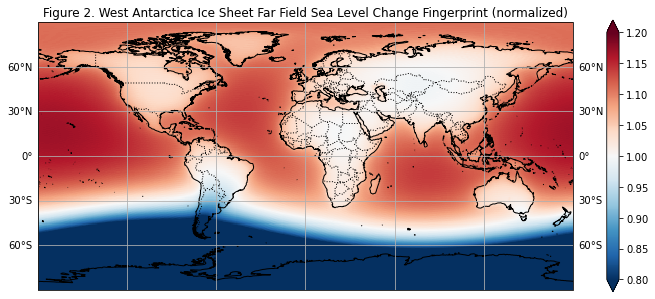

In [35]:
f1 = plt.figure(figsize=(12,10))
ax1 = f1.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
# add gridlines
ax1.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
def add_features(ax):
    # add coastal features
    ax.add_feature(cfeature.LAND)
    ax.add_feature(cfeature.OCEAN)
    ax.add_feature(cfeature.COASTLINE.with_scale('50m'))
    ax.add_feature(cfeature.BORDERS, linestyle=':')
    return ax
ax1 = add_features(ax1)
t1 = ax1.pcolormesh(e_long, -e_lat,slchange, cmap = 'RdBu_r', vmin = 0.8, vmax = 1.2)
cb = f1.colorbar(t1, ax=ax1, shrink=0.50, extend='both')
# cb.set_label(label='Ocean Function',size=5)
plt.title('Figure 2. West Antarctica Ice Sheet Far Field Sea Level Change Fingerprint (normalized)')
plt.show()

In [36]:
f1.savefig('f2_WAIS_farfield.png')

# Greenland

<ipython-input-7-05dc88166613>:2: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(e_long, e_lat, gris_h);


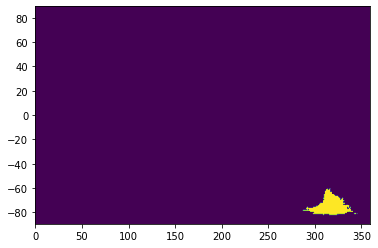

In [7]:
gris_h, w_lon, w_lat = reshape_mask(gris,lmax)
plt.pcolormesh(e_long, e_lat, gris_h);

In [8]:
#### del_i of GRIS
gris_is = topogl*gris_h
del_i = - gris_is

In [9]:
zero, w = pyshtools.expand.SHGLQ(lmax)
del_I_lm = pyshtools.expand.SHExpandGLQC(del_i,w,zero,norm=1,csphase=1,lmax_calc=lmax)
del_I_00= del_I_lm[0,0,0]
del_I_lm.shape

## construct C (theta, psi)
def ocean_function(topo):
    topo[topo > 0] = 0
    topo[topo < 0] = 1
    return topo 

oceanfunc = ocean_function(topogl)

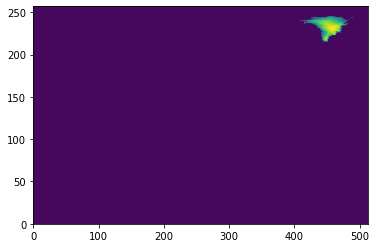

In [10]:
plt.pcolormesh(gris_is)

In [11]:
del_C_lm = pyshtools.expand.SHExpandGLQC(oceanfunc,w,zero,norm=1,csphase=1,lmax_calc=lmax)
del_C_00 = del_C_lm[0,0,0]
del_C_lm.shape

#density of water kg/m3
rho_w = 1000
#density of ice kg/m3
rho_i = 919 
# radius of earth (a) from km to m 
a = 6371*1000
# mass of the earth (kg)
Me = 5.972e24

#### INITIAL GUESS
del_S = -(rho_i/rho_w)*(np.real(del_I_00/del_C_00))*oceanfunc

# SH tranform 
del_S_lm = pyshtools.expand.SHExpandGLQC(del_S,w,zero,norm=1,csphase=1,lmax_calc=lmax)

# Rl
ls = np.arange(257)
a = 6371 * 1000 # m
M_e = 5.972e24 # kg
T_l = ((4*np.pi*a**3)/(M_e * (2*ls + 1)))
#T_l.reshape(1,257,1);

E_h = np.loadtxt('lovenumbers.txt',comments='%')[:,1]
E_k = np.loadtxt('lovenumbers.txt',comments='%')[:,2]
E_ls = (np.ones_like(E_h) + E_k - E_h)[:lmax+1]
#.reshape(1,257,1)
E_ls.shape

curly_SL_lm = E_ls*T_l*((rho_i*del_I_lm)+(rho_w*del_S_lm))

In [12]:
for i in range(5):
    
    for j in range(2):
        for l in range(257):
            for m in range(257):
                curly_SL_lm[j,l,m] = E_ls[l]*T_l[l]*((rho_i*del_I_lm[j,l,m])+(rho_w*del_S_lm[j,l,m]))
                
    ############## Inverse Spherical harmonic transform
    curly_SL_tp = pyshtools.expand.MakeGridGLQC(curly_SL_lm,zero,lmax=lmax,norm=1,csphase=1,lmax_calc=lmax)
    
    del_RO = curly_SL_tp * oceanfunc
    del_RO_00 = del_RO[0,0]
    
    delphig = -(rho_i/rho_w)*(del_I_00/del_C_00) - (del_RO_00/del_C_00)
    
    del_S_delphig = (curly_SL_tp + delphig)*oceanfunc
    
    ############## Spherical harmonic transform
    del_s_lm = pyshtools.expand.SHExpandGLQC(del_S_delphig,w,zero,norm=1,csphase=1,lmax_calc=lmax)
    
    print(i)

0
1
2
3
4


In [13]:
 
del_SL_final = curly_SL_tp + delphig

del_S_lm00 = (del_s_lm[0,0][0])/(del_C_00)

slchange = np.real(del_SL_final/del_S_lm00)

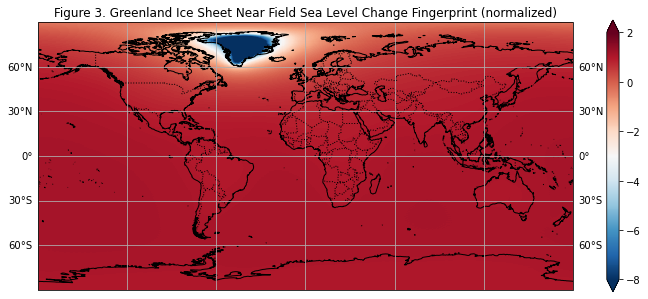

In [16]:
f1 = plt.figure(figsize=(12,10))
ax1 = f1.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
# add gridlines
ax1.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
def add_features(ax):
    # add coastal features
    ax.add_feature(cfeature.LAND)
    ax.add_feature(cfeature.OCEAN)
    ax.add_feature(cfeature.COASTLINE.with_scale('50m'))
    ax.add_feature(cfeature.BORDERS, linestyle=':')
    return ax
ax1 = add_features(ax1)
t1 = ax1.pcolormesh(e_long, -e_lat,slchange, cmap = 'RdBu_r', vmin = -8, vmax = 2)
cb = f1.colorbar(t1, ax=ax1, shrink=0.50, extend='both')
# cb.set_label(label='Ocean Function',size=5)
plt.title('Figure 3. Greenland Ice Sheet Near Field Sea Level Change Fingerprint (normalized)')
plt.show()

In [17]:
f1.savefig('F3_gris_nearfield')

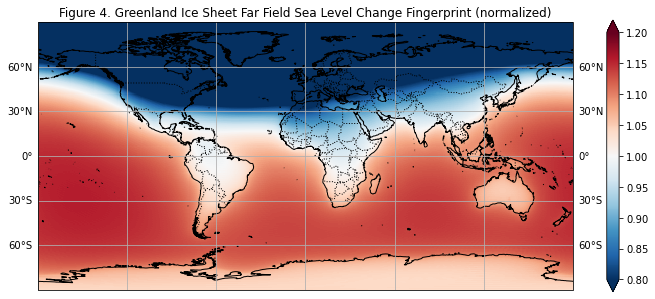

In [18]:
f1 = plt.figure(figsize=(12,10))
ax1 = f1.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
# add gridlines
ax1.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
def add_features(ax):
    # add coastal features
    ax.add_feature(cfeature.LAND)
    ax.add_feature(cfeature.OCEAN)
    ax.add_feature(cfeature.COASTLINE.with_scale('50m'))
    ax.add_feature(cfeature.BORDERS, linestyle=':')
    return ax
ax1 = add_features(ax1)
t1 = ax1.pcolormesh(e_long, -e_lat,slchange, cmap = 'RdBu_r', vmin = 0.8, vmax = 1.2)
cb = f1.colorbar(t1, ax=ax1, shrink=0.50, extend='both')
#cb.set_label(label='',size=5)
plt.title('Figure 4. Greenland Ice Sheet Far Field Sea Level Change Fingerprint (normalized)')
plt.show()

In [19]:
f1.savefig('F4_gris_farfield')

# Bonus: LGM Eurasian Ice Sheet Fingerprint

In [7]:
from netCDF4 import Dataset 

In [8]:
LGMim = 'I7G_NA.VM7_1deg.26.nc'
LGMim = Dataset(LGMim, mode  = 'r')
lonlgm = LGMim.variables['lon'][:]
latlgm = LGMim.variables['lat'][:]
iceheightlgm = LGMim.variables['stgit'][:]
ptopolgm = LGMim.variables['Topo'][:]

In [9]:
# mwp_16 = 'I7G_NA.VM7_1deg.16.nc'
# mwp16 = Dataset(mwp_16, mode  = 'r')
# lon16 = mwp16.variables['lon'][:]
# lat16 = mwp16.variables['lat'][:]
# iceheight16 = mwp16.variables['stgit'][:]
# ptopo16 = mwp16.variables['Topo'][:]

# mwp_135 = 'I7G_NA.VM7_1deg.13.5.nc'
# mwp135 = Dataset(mwp_135, mode  = 'r')
# lon135 = mwp135.variables['lon'][:]
# lat135 = mwp135.variables['lat'][:]
# iceheight135 = mwp135.variables['stgit'][:]
# ptopo135 = mwp135.variables['Topo'][:]

In [10]:
euro_mask = etopo.copy()
p = path.Path([(0,80), (0,20), (150, 20), (150, 80)])
tmp = np.array((euro_mask[:,0],euro_mask[:,1])).T
mask = p.contains_points(tmp)
euro_mask[~mask,2] = 0
euro_mask[mask,2]= 1
# reshape
eurotopo, l_long, l_lat = reshape_mask(euro_mask,lmax)

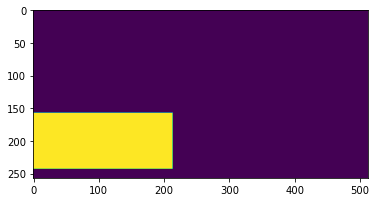

In [11]:
plt.imshow(eurotopo)

In [12]:
#put ice height onto same grid
topo_interp2 = interp.interp2d(lonlgm,latlgm,iceheightlgm)
latglq2, longlq2 = pyshtools.expand.GLQGridCoord(lmax) 

#ice height interpolated onto glg
iceheightinterpolated = topo_interp2(longlq2,latglq2)


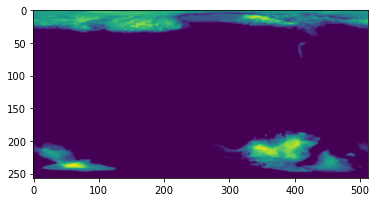

In [13]:
plt.imshow(iceheightinterpolated)

In [14]:
euro_is = iceheightinterpolated*eurotopo

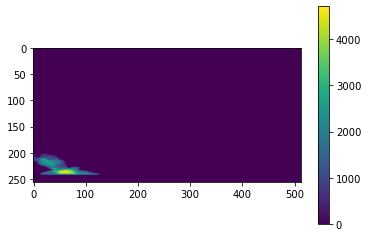

In [15]:
plt.imshow(euro_is)
plt.colorbar()

In [16]:
#### del_i
euro_is = iceheightinterpolated*eurotopo
del_i_EIS = - (iceheightinterpolated*eurotopo)

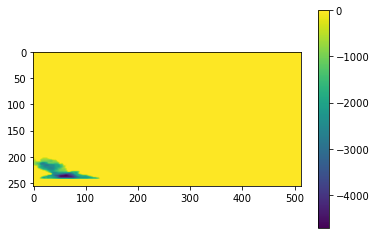

In [17]:
plt.imshow(del_i_EIS)
plt.colorbar()

In [18]:
zero, w = pyshtools.expand.SHGLQ(lmax)
del_I_lm = pyshtools.expand.SHExpandGLQC(del_i_EIS,w,zero,norm=1,csphase=1,lmax_calc=lmax)
del_I_00= del_I_lm[0,0,0]
del_I_lm.shape

(2, 257, 257)

In [19]:
## construct C (theta, psi)
def ocean_function(topo):
    topo[topo > 0] = 0
    topo[topo < 0] = 1
    return topo 

In [20]:
oceanfunc = ocean_function(topogl)

del_C_lm = pyshtools.expand.SHExpandGLQC(oceanfunc,w,zero,norm=1,csphase=1,lmax_calc=lmax)
del_C_00 = del_C_lm[0,0,0]
del_C_lm.shape

#density of water kg/m3
rho_w = 1000
#density of ice kg/m3
rho_i = 919 
# radius of earth (a) from km to m 
a = 6371*1000
# mass of the earth (kg)
Me = 5.972e24

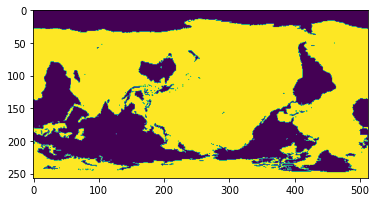

In [21]:
plt.imshow(oceanfunc)

In [22]:
#### INITIAL GUESS
del_S = -(rho_i/rho_w)*(np.real(del_I_00/del_C_00))*oceanfunc

## Spherical harmonic tranform 
del_S_lm = pyshtools.expand.SHExpandGLQC(del_S,w,zero,norm=1,csphase=1,lmax_calc=lmax)

# T_l 
ls = np.arange(257)
a = 6371 * 1000 # m
M_e = 5.972e24 # kg
T_l = ((4*np.pi*a**3)/(M_e * (2*ls + 1)))
#T_l.reshape(1,257,1);

# E_l
E_h = np.loadtxt('lovenumbers.txt',comments='%')[:,1]
E_k = np.loadtxt('lovenumbers.txt',comments='%')[:,2]
E_ls = (np.ones_like(E_h) + E_k - E_h)[:lmax+1]
#.reshape(1,257,1)
E_ls.shape

(257,)

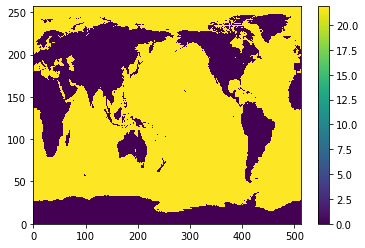

In [23]:
plt.pcolormesh(del_S)
plt.colorbar()

In [24]:
curly_SL_lm = E_ls*T_l*((rho_i*del_I_lm)+(rho_w*del_S_lm))

for i in range(5):
    for j in range(2):
        for l in range(257):
            for m in range(257):
                curly_SL_lm[j,l,m] = E_ls[l]*T_l[l]*((rho_i*del_I_lm[j,l,m])+(rho_w*del_S_lm[j,l,m]))
                
    ############## Inverse Spherical harmonic transform
    curly_SL_tp = pyshtools.expand.MakeGridGLQC(curly_SL_lm,zero,lmax=lmax,norm=1,csphase=1,lmax_calc=lmax)
    
    del_RO = curly_SL_tp * oceanfunc
    del_RO_00 = del_RO[0,0]
    
    delphig = -(rho_i/rho_w)*(del_I_00/del_C_00) - (del_RO_00/del_C_00)
    
    del_S_delphig = (curly_SL_tp + delphig)*oceanfunc
    
    ############## Spherical harmonic transform
    del_s_lm = pyshtools.expand.SHExpandGLQC(del_S_delphig,w,zero,norm=1,csphase=1,lmax_calc=lmax)
    
    print(i)

0
1
2
3
4


In [25]:
# raw data     
del_SL_final = curly_SL_tp + delphig
real_del_SL_final = np.real(del_SL_final)

In [52]:
# normalized to 1
del_S_lm00 = del_s_lm[0,0][0]/(del_C_00)
slchange = np.real(del_SL_final/del_S_lm00)

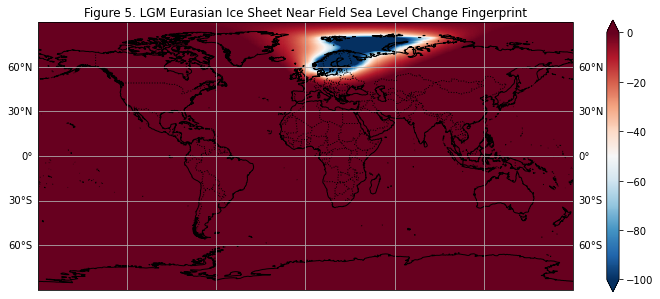

In [58]:
f1 = plt.figure(figsize=(12,10))
ax1 = f1.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
# add gridlines
ax1.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
def add_features(ax):
    # add coastal features
    ax.add_feature(cfeature.LAND)
    ax.add_feature(cfeature.OCEAN)
    ax.add_feature(cfeature.COASTLINE.with_scale('50m'))
    ax.add_feature(cfeature.BORDERS, linestyle=':')
    return ax
ax1 = add_features(ax1)
t1 = ax1.pcolormesh(e_long, -e_lat,real_del_SL_final, cmap = 'RdBu_r', vmin = -100, vmax = 0)
cb = f1.colorbar(t1, ax=ax1, shrink=0.50, extend='both')
# cb.set_label(label='Ocean Function',size=5)
plt.title('Figure 5. LGM Eurasian Ice Sheet Near Field Sea Level Change Fingerprint')
plt.show()

In [37]:
f1.savefig('F5_euro_near')

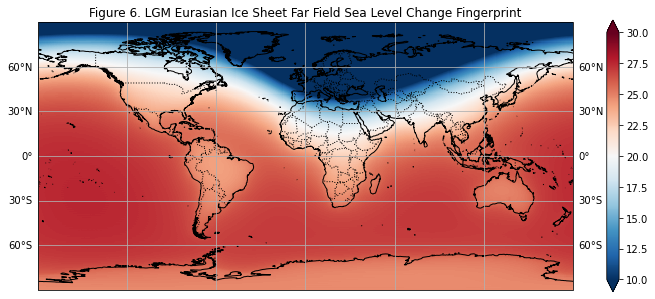

In [43]:
f1 = plt.figure(figsize=(12,10))
ax1 = f1.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
# add gridlines
ax1.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
def add_features(ax):
    # add coastal features
    ax.add_feature(cfeature.LAND)
    ax.add_feature(cfeature.OCEAN)
    ax.add_feature(cfeature.COASTLINE.with_scale('50m'))
    ax.add_feature(cfeature.BORDERS, linestyle=':')
    return ax
ax1 = add_features(ax1)
t1 = ax1.pcolormesh(e_long, -e_lat,real_del_SL_final, cmap = 'RdBu_r', vmin = 10, vmax = 30)
cb = f1.colorbar(t1, ax=ax1, shrink=0.50, extend='both')
# cb.set_label(label='Ocean Function',size=5)
plt.title('Figure 6. LGM Eurasian Ice Sheet Far Field Sea Level Change Fingerprint')
plt.show()

In [44]:
f1.savefig('F6_euro_far')